<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/styletransfer/DUDL_style_screamingBathtub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Import VGG19 and freeze all layers

In [3]:
# Import the model
vgg_net = torchvision.models.vgg19(pretrained=True)

# Freeze all layers
for p in vgg_net.parameters():
    p.requires_grad = False

# Set to evaluation mode
vgg_net.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# Send the model to the GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
vgg_net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Import two images

In [6]:
img_4_content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
img_4_style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# Initialize the target image and random numbers
img_4_target = np.random.randint(low=0, high=255, size=img_4_content.shape, dtype=np.uint8)

print(img_4_content.shape)
print(img_4_target .shape)
print(img_4_style  .shape)

(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [7]:
# Create the transform
Ts = T.Compose([T.ToTensor(),
                T.Resize(256),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Apply to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img_4_content = Ts(img_4_content).unsqueeze(0).to(device)
img_4_style   = Ts(img_4_style)  .unsqueeze(0).to(device)
img_4_target  = Ts(img_4_target) .unsqueeze(0).to(device)

print(img_4_content.shape)
print(img_4_target .shape)
print(img_4_style  .shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


Text(0.5, 1.0, 'Style picture')

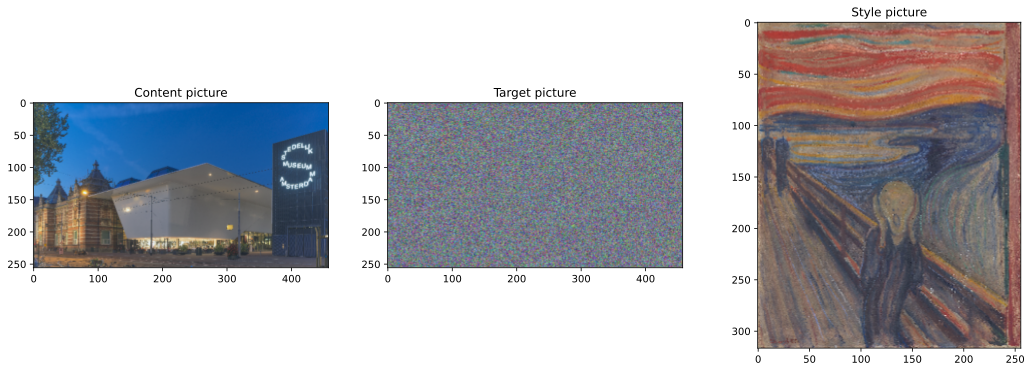

In [8]:
# "Before" pics
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

pic = img_4_content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img_4_target.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img_4_style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

# Functions to extract image feature map activations

In [16]:
def get_feature_map_acts(img, net):
    """ Function returning feature maps """

    # Initialize Feature maps as a list
    feature_maps   = []
    feature_names  = []
    conv_layer_idx = 0

    # Loop through all layers in the "features" block
    for layer_num in range(len(net.features)):
        # Print out info from this layer
        # print(layer_num, net.features[layer_num])

        # Process the image through this layer
        img = net.features[layer_num](img)

        # Store the image if it's a conv2d layer
        if ('Conv2d' in str(net.features[layer_num])):
            feature_maps .append(img)
            feature_names.append(f'ConvLayer_{conv_layer_idx}')
            conv_layer_idx += 1
        
    return feature_maps, feature_names

In [23]:
def gram_matrix(M):
    """ Returns the Gram matrix of the feature activation map """
    # Reshape to 2D
    _, chans, height, width = M.shape
    M = M.reshape(chans, height * width)

    # Compute and return covariance matrix
    gram = torch.mm(M, M.t()) / (chans * height * width)

    return gram

In [17]:
# Inspect the output of the function
feat_maps, feat_names = get_feature_map_acts(img_4_content, vgg_net)

# Print out some info
for i in range(len(feat_names)):
    print(f'Feature map {feat_names[i]} is size {feat_maps[i].shape}')

Feature map ConvLayer_0 is size torch.Size([1, 64, 256, 458])
Feature map ConvLayer_1 is size torch.Size([1, 64, 256, 458])
Feature map ConvLayer_2 is size torch.Size([1, 128, 128, 229])
Feature map ConvLayer_3 is size torch.Size([1, 128, 128, 229])
Feature map ConvLayer_4 is size torch.Size([1, 256, 64, 114])
Feature map ConvLayer_5 is size torch.Size([1, 256, 64, 114])
Feature map ConvLayer_6 is size torch.Size([1, 256, 64, 114])
Feature map ConvLayer_7 is size torch.Size([1, 256, 64, 114])
Feature map ConvLayer_8 is size torch.Size([1, 512, 32, 57])
Feature map ConvLayer_9 is size torch.Size([1, 512, 32, 57])
Feature map ConvLayer_10 is size torch.Size([1, 512, 32, 57])
Feature map ConvLayer_11 is size torch.Size([1, 512, 32, 57])
Feature map ConvLayer_12 is size torch.Size([1, 512, 16, 28])
Feature map ConvLayer_13 is size torch.Size([1, 512, 16, 28])
Feature map ConvLayer_14 is size torch.Size([1, 512, 16, 28])
Feature map ConvLayer_15 is size torch.Size([1, 512, 16, 28])


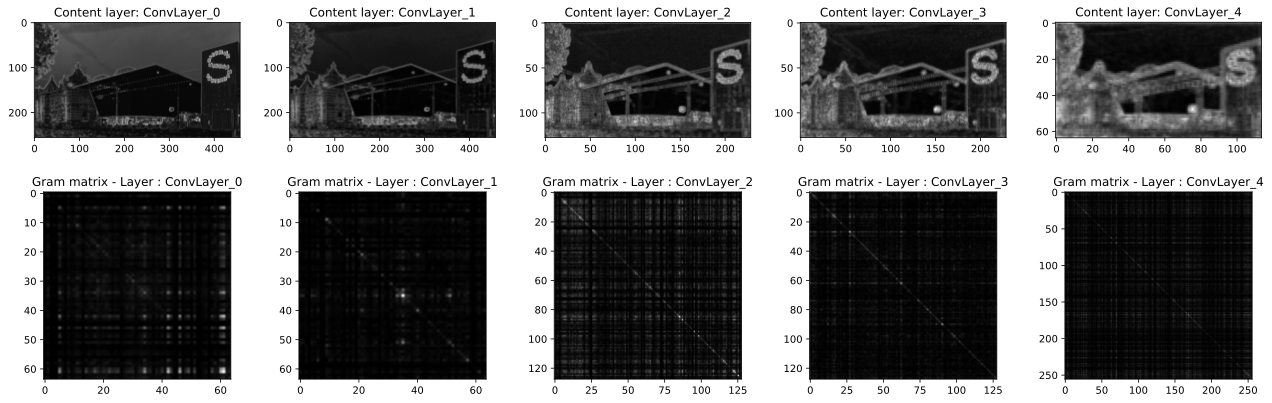

In [19]:
# See what the "content" image looks like
content_feature_maps, content_feature_names = get_feature_map_acts(img_4_content, vgg_net)

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):

    # Average over all feature maps from this layer, and normalize
    pic = np.mean(content_feature_maps[i].cpu().squeeze().numpy(), axis=0)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0, i].imshow(pic, cmap='gray')
    axs[0, i].set_title(f'Content layer: {content_feature_names[i]}')

    # Show the gram matrix
    pic = gram_matrix(content_feature_maps[i]).cpu().numpy()
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[1, i].imshow(pic, cmap='gray')
    axs[1, i].set_title(f'Gram matrix - Layer : {content_feature_names[i]}')

plt.tight_layout()
plt.show()

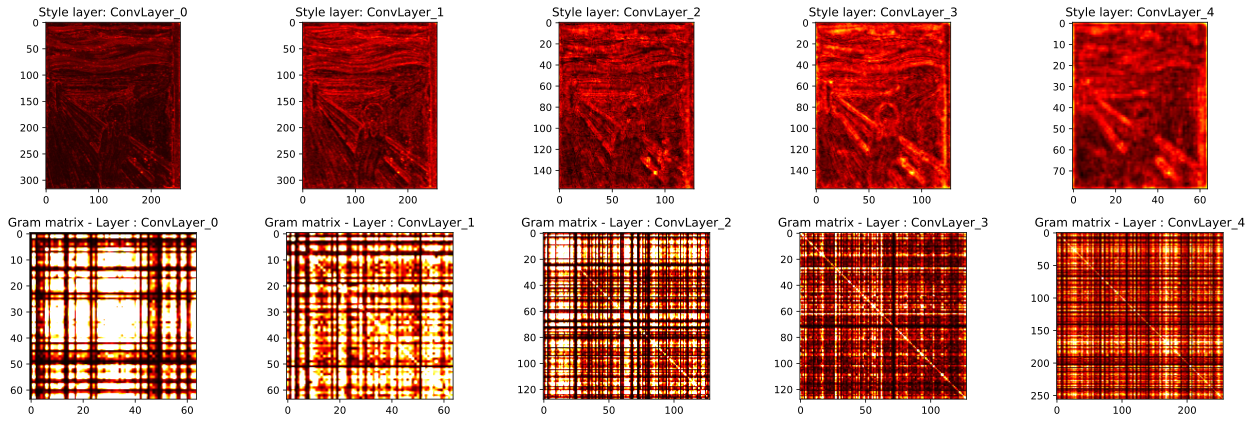

In [20]:
# See what the "style" image looks like
style_feature_maps, style_feature_names = get_feature_map_acts(img_4_style, vgg_net)

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):

    # Average over all feature maps from this layer, and normalize
    pic = np.mean(style_feature_maps[i].cpu().squeeze().numpy(), axis=0)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0, i].imshow(pic, cmap='hot')
    axs[0, i].set_title(f'Style layer: {style_feature_names[i]}')

    # Show the gram matrix
    pic = gram_matrix(style_feature_maps[i]).cpu().numpy()
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[1, i].imshow(pic, cmap='hot', vmax=0.1)
    axs[1, i].set_title(f'Gram matrix - Layer : {style_feature_names[i]}')

plt.tight_layout()
plt.show()

# Now for the transfer

In [21]:
# Layers to use
layers_4_content = ['ConvLayer_1', 'ConvLayer_4']
layers_4_style   = ['ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4', 'ConvLayer_5']
weights_4_style  = [     1,             0.5,           0.5,          0.2,            0.1     ] 

In [24]:
# Make a copy of the target image and push to GPU
target = img_4_target.clone()
target.requires_grad = True
target = target.to(device)
style_scaling = 1e6

# Number of epochs to train
num_epochs = 1500

# Optimizer for backprop
optimizer = torch.optim.RMSprop([target], lr=0.005)

for epoch_i in range(num_epochs):
    # Extract the target feature maps
    target_feature_maps, target_feature_names = get_feature_map_acts(target, vgg_net)

    # Initialize the individual loss components
    style_loss   = 0
    content_loss = 0

    # Loop over layers
    for layer_i in range(len(target_feature_names)):

        # Compute the content loss
        if (target_feature_names[layer_i] in layers_4_content):
            content_loss += torch.mean((target_feature_maps[layer_i] - content_feature_maps[layer_i]) ** 2)

        # Compute the style loss
        if (target_feature_names[layer_i] in layers_4_style):

            # Gram matrix
            G_target = gram_matrix(target_feature_maps[layer_i])
            G_style  = gram_matrix(style_feature_maps [layer_i])

            # Compute their loss
            style_loss += torch.mean((G_target - G_style) ** 2) * weights_4_style[layers_4_style.index(target_feature_names[layer_i])]

    # Combined loss
    combi_loss = style_scaling * style_loss + content_loss

    # Backprop
    optimizer.zero_grad()
    combi_loss.backward()
    optimizer.step()

# Let's have a looksie!

[]

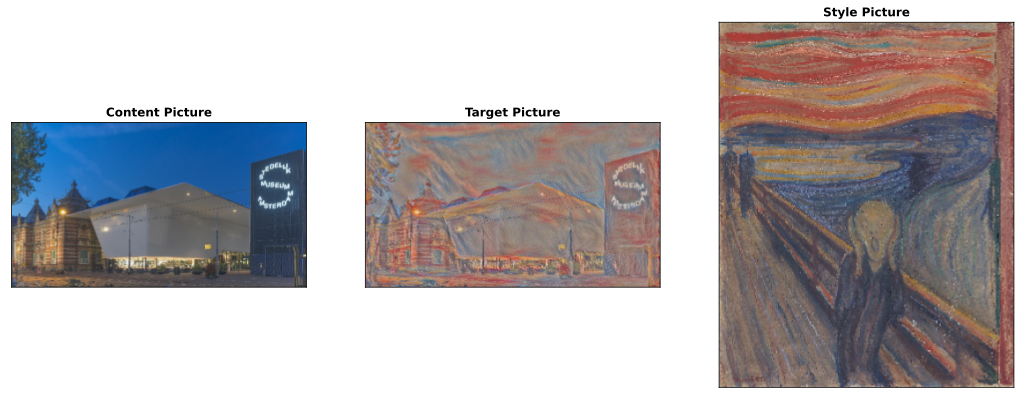

In [27]:
# The "after" pic
fig, ax = plt.subplots(1, 3, figsize=(18, 11))

pic = img_4_content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content Picture', fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1, 2, 0))
ax[1].imshow(pic)
ax[1].set_title('Target Picture', fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img_4_style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style Picture', fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

# Additional explorations
1) The minimization loss has two components (style and content). Modify the code to store these two components in a
   Nx2 matrix (for N training epochs). Then plot them. This will help you understand and adjust the styleScaling gain
   factor.

2) Change the layers for minimizing losses to content and style images. Do you notice an effect of minimizing the
   earlier vs. later layers? How about more vs. fewer layers?

3) It's pretty neat to see the target image evolve over time. Modify the code to save the target image every, e.g.,
   100 epochs. Then you can make a series of images showing how the noise transforms into a lovely picture.

4) The target picture was initialized as random noise. But it doesn't need to be. It can be initialized to anything
   else. Try the following target initializations: (1) the content picture; (2) the style picture; (3) a completely
   different picture (e.g., a picture of you or a cat or the Taj Mahal).